In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

# importing DL libraries

from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from tqdm import tqdm

import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

2024-05-15 11:23:22.437372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 11:23:22.437488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 11:23:22.583524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (50, 50)

def load_data():
    datasets = ['/kaggle/input/face-expression-recognition-dataset/images/train/']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            count = 0
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
#                 image = cv2.imread(img_path)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#                 image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
                # Taking only 100 images from of each type because of 
                # MemoryError: Unable to allocate 3.53 GiB for an array with shape (14034, 150, 150, 3) and data type float32
                count = count + 1
                if count == 2000:
                    break
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [3]:
(images, labels) = load_data()[0]

Loading /kaggle/input/face-expression-recognition-dataset/images/train/


 28%|██▊       | 1999/7164 [00:11<00:29, 177.82it/s]


In [4]:
permutation  = np.random.permutation(len(images))

shuffled_images = images[permutation]
shuffled_labels = labels[permutation]

In [5]:
# Memory taken by array
(images.nbytes/1024)/1024

118.59893798828125

In [6]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(shuffled_images, shuffled_labels, test_size=0.1, shuffle=True)

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((11192, 50, 50), (11192,), (1244, 50, 50), (1244,))

In [7]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

In [8]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

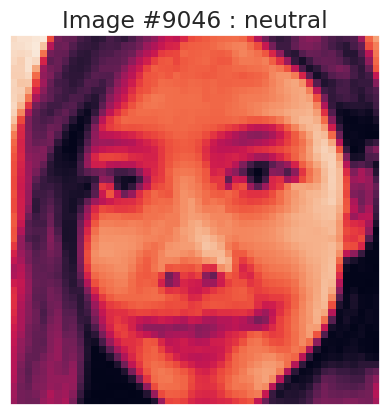

In [9]:
display_random_image(class_names, train_images, train_labels)

In [115]:
# import keras_tuner
# from tensorflow.keras import layers 

# def build_model(hp):
#     model = tf.keras.Sequential()
    
#     no_of_filters_layer1 = hp.Int("no_of_filters_layer1", min_value=16, max_value=128, step=16)
    
#     model.add(Conv2D(name="conv2d_layer1", filters=no_of_filters_layer1, kernel_size=(3, 3), padding='same', input_shape=(50, 50, 1)))
    
#     if hp.Boolean("BatchNormalization_1"):
#         model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     dropuout_rate_1 = hp.Float("dropuout_rate_1", min_value=0, max_value=0.4, step=0.2)
#     model.add(layers.Dropout(rate=dropuout_rate_1))
              
              

#     hp_cnn_layers = hp.Int('cnn_layers', min_value=1, max_value=4, step=1)
#     for i in range(hp_cnn_layers):
#         no_of_filters = hp.Int(name=f'no_of_filters_{i}', min_value=32, max_value=256, step=16)
        
#         model.add(Conv2D(name=f'conv2d_layer_{i}', filters=no_of_filters, kernel_size=(3, 3), padding='same'))
#         if hp.Boolean("BatchNormalization_1"):
#             model.add(BatchNormalization())
#         model.add(Activation('relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         dropuout_rate_1 = hp.Float(name=f'dropout_rate_{i}', min_value=0, max_value=0.4, step=0.2)
#         model.add(layers.Dropout(rate=dropuout_rate_1))
    
        
#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(32, activation='relu'))
#     model.add(tf.keras.layers.Dense(7, activation='softmax'))    
        
#     # Define the optimizer learning rate as a hyperparameter.
#     learning_rate = hp.Float("lr", min_value=0.0001, max_value=0.01, sampling="log")
#     model.compile(
#         optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
#         loss="sparse_categorical_crossentropy",
#         metrics=["accuracy"],
#     )
#     print(model.summary())
#     tf.keras.utils.plot_model(model)
#     return model

In [116]:
# build_model(keras_tuner.HyperParameters())

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer1 (Conv2D)          │ (None, 50, 50, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_0 (Conv2D)         │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,519 (595.78 KB)

 Trainable params: 152,519 (595.78 KB)

 Non-trainable params: 0 (0.00 B)

None


<Sequential name=sequential_2, built=True>

In [117]:
# tuner = keras_tuner.RandomSearch(
#     hypermodel=build_model,
#     objective="val_accuracy",
#     max_trials=30,
#     overwrite=True,
#     directory="my_dir",
#     project_name="helloworld",
# )

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer1 (Conv2D)          │ (None, 50, 50, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_0 (Conv2D)         │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       147,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,519 (595.78 KB)

 Trainable params: 152,519 (595.78 KB)

 Non-trainable params: 0 (0.00 B)

None


In [121]:
# tuner.search(train_images, train_labels, epochs=20, validation_split=0.2, callbacks=[tf.keras.callbacks.TensorBoard("/tmp/tb_logs")])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_layer1 (Conv2D)          │ (None, 50, 50, 80)     │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 50, 50, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_layer_0 (Conv2D)         │ (None, 25, 25, 48)     │        34,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 25, 25, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6912)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       221,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,855 (1003.34 KB)

 Trainable params: 256,855 (1003.34 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
113/280 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.1642 - loss: 1.9134

KeyboardInterrupt: 

In [122]:
# tuner.results_summary()

Results summary
Results in my_dir/helloworld
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
no_of_filters_layer1: 80
BatchNormalization_1: False
dropuout_rate_1: 0.0
cnn_layers: 1
no_of_filters_0: 48
dropout_rate_0: 0.0
lr: 0.002907991515463253


In [11]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (50, 50, 1)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
model2.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 2, 2, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,863 (413.53 KB)

 Trainable params: 105,863 (413.53 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model2.fit(train_images, train_labels, batch_size=128, epochs=100, validation_split = 0.2)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - accuracy: 0.1711 - loss: 1.9015 - val_accuracy: 0.1630 - val_loss: 1.9087
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.1761 - loss: 1.8854 - val_accuracy: 0.2041 - val_loss: 1.8926
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 0.1912 - loss: 1.8692 - val_accuracy: 0.2175 - val_loss: 1.8677
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 0.2288 - loss: 1.8294 - val_accuracy: 0.2675 - val_loss: 1.7838
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - accuracy: 0.2747 - loss: 1.7596 - val_accuracy: 0.2881 - val_loss: 1.7583
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.2928 - loss: 1.7391 - val_accuracy: 0.3310 - val_loss: 1.6949
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.3289 - loss: 1.6873 - val_accuracy: 0.3497 - val_loss: 1.6513
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.3598 - loss: 1.6435 - val_a

In [2]:
plt.plot(history.history['accuracy'], label = "acc")
plt.plot(history.history['val_accuracy'], label = "val_acc")
plt.title("train_acc vs val_acc")
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.legend()

NameError: name 'plt' is not defined